We have 8 csv files:

- Bullying_1: aggression_parsed_dataset.csv       (115864 rows × 5 columns)
- Bullying_2: attack_parsed_dataset.csv           (115864 rows × 5 columns) 
- Bullying_3: twitter_parsed_dataset.csv          (16851 rows × 5 columns) 
- Bullying_4: twitter_racism_parsed_dataset.csv   (13471 rows × 5 columns) 
- Bullying_5: twitter_sexism_parsed_dataset.csv   (14881 rows × 5 columns) 
- Bullying_6: youtube_parsed_dataset.csv          (3464 rows × 10 columns) 
- Bullying_7: toxicity_parsed_dataset.csv         (159686 rows × 5 columns) 
- Bullying_8: kaggle_parsed_dataset.csv           (8799 rows × 4 columns) 


https://www.kaggle.com/datasets/saurabhshahane/cyberbullying-dataset?select=aggression_parsed_dataset.csv

In [16]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import joblib

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import load_model

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)


In [2]:
# Loading the data
B = pd.read_csv("n_df.csv", index_col=0)

In [3]:
B

,ed_label_0,ed_label_1,oh_label,Processed_Text
index,,,,
0,0.9,0.1,0,make analogy mathematical term envisioning dis...
1,1.0,0.0,0,clarification zundark right checked wikipedia ...
2,1.0,0.0,0,elected electoral
3,1.0,0.0,0,entry devotchka coworker korea tell difference...
4,0.8,0.2,0,please relate ozone hole increase cancer provi...
...,...,...,...,...
159681,1.0,0.0,0,source exactly exude sense impartiality newswe...
159682,1.0,0.0,0,institute historical review peer reviewed jour...
159683,1.0,0.0,0,trying describe article serious step whereas s...


In [4]:
# sample of a 'not bullying text (0)'
B.loc[B["oh_label"]==0].sample()

,ed_label_0,ed_label_1,oh_label,Processed_Text
index,,,,
4350,1.0,0.0,0,please insert photograph lead star miniseries ...


In [5]:
# sample of a 'bullying text (1)'
B.loc[B["oh_label"]==1].sample()

,ed_label_0,ed_label_1,oh_label,Processed_Text
index,,,,
124209,0.1,0.9,1,fuck samuel johnson idea ridiculous pathetic s...


In [6]:
# distribution of bullying vs. no-bullying content
B['oh_label'].value_counts()

oh_label
0    144324
1     15362
Name: count, dtype: int64

### Text Preprocessing

In [ ]:
### Text Preprocessing:
# Cleaning and preprocessing the text data. This involves tasks like removing stop words, handling emojis, 
# and converting text to lowercase.
# Tokenizing the text to convert it into a format suitable for machine learning algorithms.

In [ ]:
# checking null values
B.isna().sum()

In [ ]:
# Preprocessing the text. Cenverting to lower_case, removing any special characters/symbols and removing extra spaces.
def clean_text(text):
    if not isinstance(text, str):
        # If the input is not a string, return an empty string or handle it as needed
        return ''

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters and symbols
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE)  # Remove extra spaces
    words = [word for word in text.split() if word.isalnum() and word.isalpha()]  # Split the text into words and keep only alphanumeric words
    cleaned_text = ' '.join(words)  # Join the words with a space
    return cleaned_text

In [ ]:
# Apply the clean_text function to the "Text" column
B['Cleaned_Text'] = B['Processed_Text'].apply(clean_text)
B[['Cleaned_Text']]

In [ ]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.data.path.append('/root/nltk_data/corpora/')

In [ ]:
# Tokenizing and removing stopwords

def tokenizing_and_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    text = " ".join(filtered_tokens)
    return text

In [ ]:
# Apply the tokenizing_and_stopwords function to the "Cleaned_Text" column
B['ctns_Text'] = B['Cleaned_Text'].apply(tokenizing_and_stopwords)  
B[['ctns_Text']] #ctns_Text = cleaned, tokenized, no stopwords

In [ ]:
B['ctns_Text'][94]

In [ ]:
# lemmatization aims to reduce words to their base or root form.

def lemmatization_and_stopwords(text):
    if not text:
        return ""
    tokens = word_tokenize(text)
    clean_text = []
    lemmatizer = nltk.WordNetLemmatizer()
    for token in tokens:
        if token.lower() not in stopwords.words('english') and len(token) > 3:
            token = lemmatizer.lemmatize(token)
            clean_text.append(token)
    result_text = " ".join(clean_text)
    return result_text

In [ ]:
# Apply lemmatization function to the "ctns_Text" column
B['lemm_text'] = B['ctns_Text'].apply(lemmatization_and_stopwords)
B[['lemm_text']]

In [ ]:
B['lemm_text'][57]

In [ ]:
# To show all the 'processed text' columns
B

In [ ]:
B['text_len'] = B['lemm_text'].apply(lambda text: len(text.split()))

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='text_len', data=B[B['text_len']<10], palette='mako')
plt.title('Coments with less than 10 words', fontsize=12)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=B[(B['text_len']<=100) & (B['text_len']>50)], palette='mako')
plt.title('Coments with high number of words (50-100)', fontsize=12)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
B.sort_values(by=["text_len"], ascending=False)

In [ ]:
B['text_len'].sum()

In [ ]:
# top 10 words 
vectorizer = CountVectorizer()
word_matrix = vectorizer.fit_transform(B['Processed_Text'])
words = vectorizer.get_feature_names_out()
word_frequencies = word_matrix.sum(axis=0)

word_freq_df = pd.DataFrame({'word': words, 'frequency': word_frequencies.tolist()[0]})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

top_words_count = 50  
top_words = word_freq_df.head(top_words_count)

# Plot the top words
plt.figure(figsize=(10, 6))
plt.bar(top_words['word'], top_words['frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_words_count} Words in lemm_text')
plt.xticks(rotation=90)
plt.show()

In [ ]:
B['text_len'].sum()

### Splitting the Dataset - X, y

In [7]:
X = B['Processed_Text']
y = B[['oh_label']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set length:", len(X_train), len(y_train))
print("Testing set length:", len(X_test), len(y_test))

Training set length: 127748 127748
Testing set length: 31938 31938


### Feature Extraction

In [8]:
### Feature Extraction: Extracting relevant features from the text data. 
# Using word embeddingsb (Word2Vec, GloVe) to capture semantic relationships between words

In [9]:
B['Processed_Text'] = B['Processed_Text'].apply(lambda text: [] if pd.isna(text) else text)

sentences = B['Processed_Text']
model = Word2Vec(sentences, vector_size=1000, window=5, min_count=1, workers=4)
model.save("t4_word2vec.model")

In [10]:
X_train.fillna("", inplace=True)
X_test.fillna("", inplace=True)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have a consistent length
max_sequence_length = 500  # You can adjust this based on your data
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

print("Original Training set shape:", X_train_padded.shape, y_train.shape)

# Load pre-trained Word2Vec model
word2vec_model = Word2Vec.load("word2vec.model")

# Create an embedding matrix using Word2Vec
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec_model.vector_size))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Save the tokenizer
joblib.dump(tokenizer, 't4_saved_tokenizer.joblib') 

Original Training set shape: (127748, 500) (127748, 1)


['t4_saved_tokenizer.joblib']

### Handling Imbalanced Data

In [11]:
### Handling Imbalanced Data for the training set

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_sm, y_sm = smote.fit_resample(X_train_padded, y_train)

print("Original Training set shape:", X_train_padded.shape, y_train.shape)
print("Resampled Training set shape:", X_sm.shape, y_sm.shape)

Original Training set shape: (127748, 500) (127748, 1)
Resampled Training set shape: (230932, 500) (230932, 1)


#### MODEL - LOGISTIC REGRESSION

In [ ]:
### Build the Model: Choose a suitable machine learning algorithm
# i.e. random forrest, logistic regression, support vector machines, or deep learning) and build the model.

In [12]:
# Logistic Regression model

log_model = LogisticRegression()
log_model.fit(X_sm, y_sm)

# Predictions on the resampled training set
y_pred_train_log = log_model.predict(X_sm)

# Predictions on the test set
y_pred_test_log = log_model.predict(X_test_padded)  

performance_log = pd.DataFrame({'Error_metric': ['Accuracy', 'Precision', 'Recall'],
                                'Train': [accuracy_score(y_sm, y_pred_train_log),
                                          precision_score(y_sm, y_pred_train_log, average='weighted'),  # Use 'weighted' for multi-label
                                          recall_score(y_sm, y_pred_train_log, average='weighted')],
                                'Test': [accuracy_score(y_test, y_pred_test_log),
                                         precision_score(y_test, y_pred_test_log, average='weighted'),
                                         recall_score(y_test, y_pred_test_log, average='weighted')]})

display(performance_log)

C:\Users\calum\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Error_metric,Train,Test
0,Accuracy,0.604200,0.511585
1,Precision,0.608507,0.860765
2,Recall,0.604200,0.511585


#### MODEL - RANDOM FOREST

In [13]:
rfc_ops = {
    "max_depth": 6,
    "min_samples_leaf": 20, ## by default 1 . This is the minimun number of data points per leaf
    "n_estimators": 100, ## number os trees in the forest
    "bootstrap": True, # default is true
    "oob_score": True, # out of bag can be retrieved
    "random_state": 42
}

clf = RandomForestClassifier(**rfc_ops)
clf.fit(X_sm, y_sm)

# Predictions on the resampled training set
y_pred_train_rfc = clf.predict(X_sm)

# Predictions on the test set
y_pred_test_rfc = clf.predict(X_test_padded)

performance_rfc = pd.DataFrame({'Error_metric': ['Accuracy', 'Precision', 'Recall'],
                                'Train': [accuracy_score(y_sm, y_pred_train_rfc),
                                          precision_score(y_sm, y_pred_train_rfc, average='weighted'),
                                          recall_score(y_sm, y_pred_train_rfc, average='weighted')],
                                'Test': [accuracy_score(y_test, y_pred_test_rfc),
                                         precision_score(y_test, y_pred_test_rfc, average='weighted'),
                                         recall_score(y_test, y_pred_test_rfc, average='weighted')]})

display(performance_rfc)

,Error_metric,Train,Test
0,Accuracy,0.635356,0.568101
1,Precision,0.637905,0.862406
2,Recall,0.635356,0.568101


#### MODEL - NAIVE BAYES

In [14]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_sm, y_sm)

# Predictions on the resampled training set
y_pred_train = naive_bayes_model.predict(X_sm)

# Predictions on the test set
y_pred_test = naive_bayes_model.predict(X_test_padded)

performance_naive_bayes = pd.DataFrame({'Error_metric': ['Accuracy', 'Precision', 'Recall'],
                                         'Train': [accuracy_score(y_sm, y_pred_train),
                                                   precision_score(y_sm, y_pred_train, average='weighted'),
                                                   recall_score(y_sm, y_pred_train, average='weighted')],
                                         'Test': [accuracy_score(y_test, y_pred_test),
                                                  precision_score(y_test, y_pred_test, average='weighted'),
                                                  recall_score(y_test, y_pred_test, average='weighted')]})


display(performance_naive_bayes)
print(classification_report(y_test, y_pred_test))

,Error_metric,Train,Test
0,Accuracy,0.571432,0.321529
1,Precision,0.610243,0.870482
2,Recall,0.571432,0.321529


              precision    recall  f1-score   support

           0       0.95      0.26      0.41     28858
           1       0.11      0.87      0.20      3080

    accuracy                           0.32     31938
   macro avg       0.53      0.57      0.31     31938
weighted avg       0.87      0.32      0.39     31938



#### TENSORFLOW

In [17]:
### This one!

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=word2vec_model.vector_size,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))

model.add(LSTM(units=100))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification, 1 output unit, sigmoid activation

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 1000)         144008000 
                                                                 
 lstm (LSTM)                 (None, 100)               440400    
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 144454929 (551.05 MB)
Trainable params: 446929 (1.70 MB)
Non-trainable params: 144008000 (549.35 MB)
_________________________________________________________________


In [18]:
# Create callback to stop training process after getting >90% accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Assuming you are logging 'recall' and 'val_recall' during training
        train_recall = logs.get('recall', 0)
        val_recall = logs.get('val_recall', 0)
        if train_recall > 0.90 and val_recall > 0.90:
            self.model.stop_training = True
            print("\nThe recall of training and validation data has reached > 90%")

In [19]:
# No one-hot encoding needed for binary classification
callbacks = myCallback()

model.fit(X_train_padded, 
          y_train, epochs=10, 
          batch_size=32, 
          validation_data=(X_test_padded, y_test))

Epoch 1/10
3993/3993 [==============================] - 5122s 1s/step - loss: 0.3204 - accuracy: 0.9038 - val_loss: 0.3183 - val_accuracy: 0.9036
Epoch 2/10
3993/3993 [==============================] - 4627s 1s/step - loss: 0.3171 - accuracy: 0.9038 - val_loss: 0.3175 - val_accuracy: 0.9036
Epoch 3/10
3993/3993 [==============================] - 4013s 1s/step - loss: 0.3170 - accuracy: 0.9039 - val_loss: 0.3176 - val_accuracy: 0.9035
Epoch 4/10
3993/3993 [==============================] - 4208s 1s/step - loss: 0.3171 - accuracy: 0.9039 - val_loss: 0.3173 - val_accuracy: 0.9036
Epoch 5/10
3993/3993 [==============================] - 4325s 1s/step - loss: 0.3169 - accuracy: 0.9039 - val_loss: 0.3180 - val_accuracy: 0.9036
Epoch 6/10
3993/3993 [==============================] - 4338s 1s/step - loss: 0.3171 - accuracy: 0.9039 - val_loss: 0.3172 - val_accuracy: 0.9036
Epoch 7/10
3993/3993 [==============================] - 3736s 936ms/step - loss: 0.3170 - accuracy: 0.9039 - val_loss: 0.318

In [20]:
evaluation_result = model.evaluate(X_test_padded, y_test)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

999/999 [==============================] - 374s 375ms/step - loss: 0.3171 - accuracy: 0.9036
Test Loss: 0.3171359896659851
Test Accuracy: 0.9035631418228149


In [21]:
y_pred_train_prob = model.predict(X_train_padded)
y_pred_test_prob = model.predict(X_test_padded)

# Convert probabilities to class labels (using a threshold, e.g., 0.5)
y_pred_train = (y_pred_train_prob > 0.5).astype(int).reshape(-1)
y_pred_test = (y_pred_test_prob > 0.5).astype(int).reshape(-1)

# Calculate performance metrics
performance_tf = pd.DataFrame({'Error_metric': ['Accuracy', 'Precision', 'Recall'],
                             'Train': [accuracy_score(y_train, y_pred_train),
                                       precision_score(y_train, y_pred_train, average='weighted', zero_division=1),
                                       recall_score(y_train, y_pred_train, average='weighted', zero_division=1)],
                             'Test': [accuracy_score(y_test, y_pred_test),
                                      precision_score(y_test, y_pred_test, average='weighted', zero_division=1),
                                      recall_score(y_test, y_pred_test, average='weighted', zero_division=1)]})


display(performance_tf)

999/999 [==============================] - 384s 384ms/step


,Error_metric,Train,Test
0,Accuracy,0.903905,0.903563
1,Precision,0.913139,0.912863
2,Recall,0.903905,0.903563


In [22]:
# Save the model in SavedModel format .keras zip file
model.save('tf4_model.keras')

#### >>> TESTING THE MODELS <<<

In [23]:
# Comparing the models

print("Performance for All Models: \n")
print("LOGISTIC REGRESSION")
display(performance_log)
print("\nRANDOM FOREST")
display(performance_rfc)
print("\nNAIVE BAYES")
display(performance_naive_bayes)
print("\nTENSOR FLOW")
display(performance_tf)

Performance for All Models: 

LOGISTIC REGRESSION


,Error_metric,Train,Test
0,Accuracy,0.604200,0.511585
1,Precision,0.608507,0.860765
2,Recall,0.604200,0.511585



RANDOM FOREST


,Error_metric,Train,Test
0,Accuracy,0.635356,0.568101
1,Precision,0.637905,0.862406
2,Recall,0.635356,0.568101



NAIVE BAYES


,Error_metric,Train,Test
0,Accuracy,0.571432,0.321529
1,Precision,0.610243,0.870482
2,Recall,0.571432,0.321529



TENSOR FLOW


,Error_metric,Train,Test
0,Accuracy,0.903905,0.903563
1,Precision,0.913139,0.912863
2,Recall,0.903905,0.903563


In [24]:

'''LOGISTIC REGRESSION
Error_metric	Train	Test
0	Accuracy	0.604200	0.511585
1	Precision	0.608507	0.860765
2	Recall	0.604200	0.511585

RANDOM FOREST
Error_metric	Train	Test
0	Accuracy	0.635356	0.568101
1	Precision	0.637905	0.862406
2	Recall	0.635356	0.568101

NAIVE BAYES
Error_metric	Train	Test
0	Accuracy	0.571432	0.321529
1	Precision	0.610243	0.870482
2	Recall	0.571432	0.321529

TENSOR FLOW
Error_metric	Train	Test
0	Accuracy	0.903905	0.903563
1	Precision	0.913139	0.912863
2	Recall	0.903905	0.903563


'\nLOGISTIC REGRESSION\nError_metric\tTrain\tTest\n0\tAccuracy\t0.600159\t0.510646\n1\tPrecision\t0.604074\t0.859725\n2\tRecall\t0.600159\t0.510646\n\nRANDOM FOREST\nError_metric\tTrain\tTest\n0\tAccuracy\t0.655314\t0.577995\n1\tPrecision\t0.658777\t0.862576\n2\tRecall\t0.655314\t0.577995\n\nNAIVE BAYES\nError_metric\tTrain\tTest\n0\tAccuracy\t0.571060\t0.328418\n1\tPrecision\t0.606347\t0.869915\n2\tRecall\t0.571060\t0.328418\n\nTENSOR FLOW\nError_metric\tTrain\tTest\n0\tAccuracy\t0.904006\t0.903501\n1\tPrecision\t0.908650\t0.816421\n2\tRecall\t0.904006\t0.903501\n'

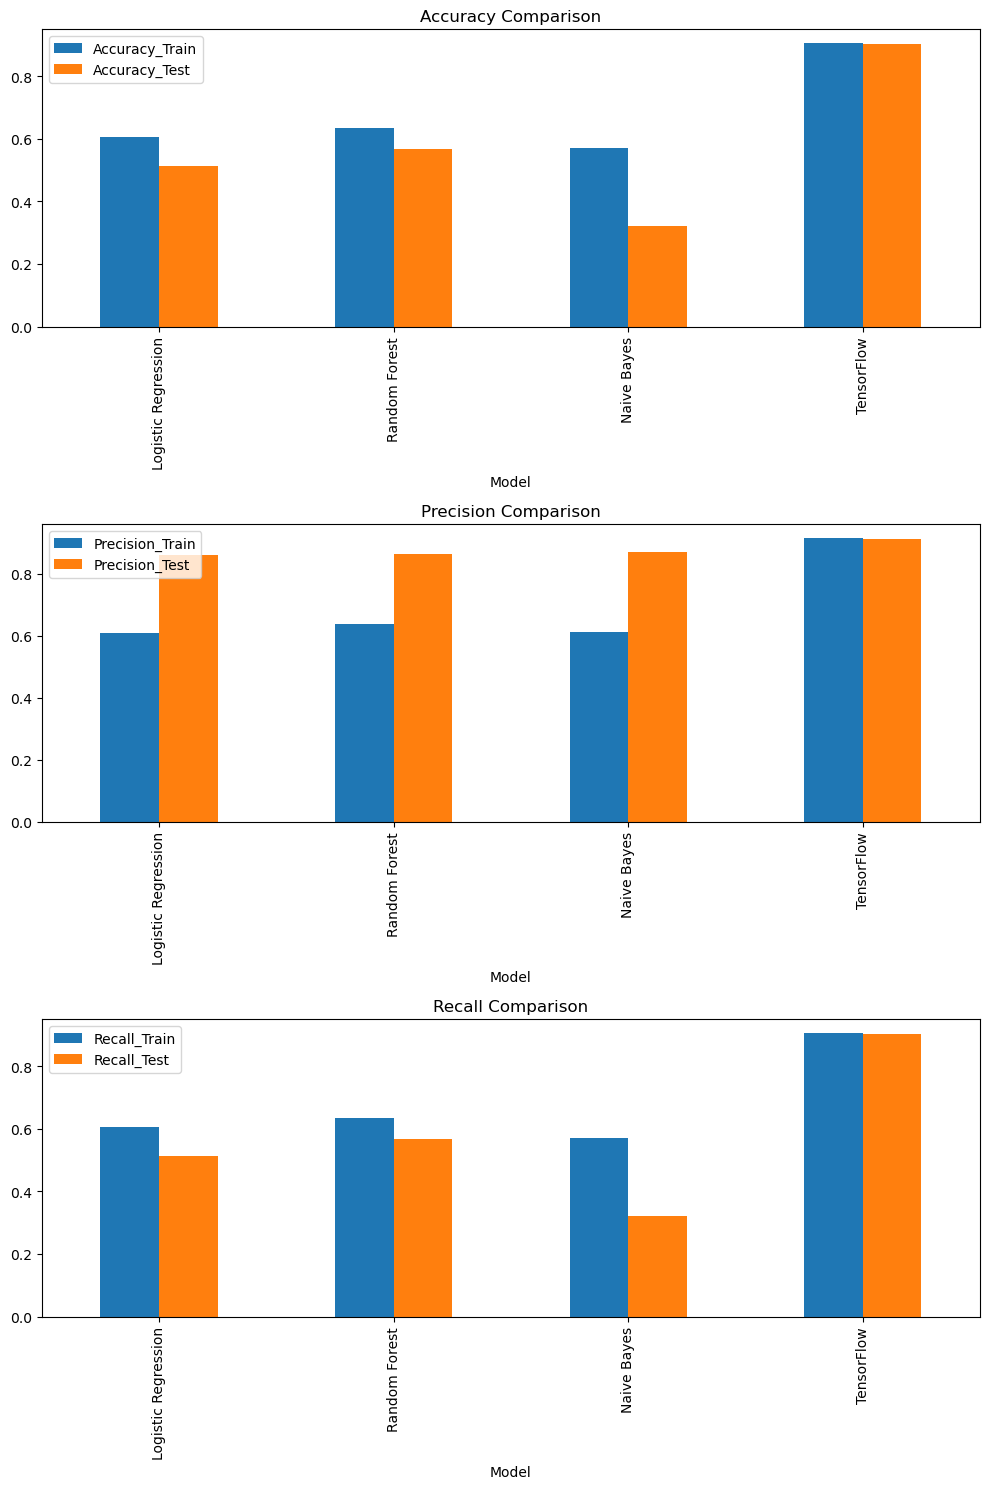

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the provided results
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'TensorFlow'],
    'Accuracy_Train': [0.604200, 0.635356, 0.571432, 0.903905],
    'Accuracy_Test': [0.511585, 0.568101, 0.321529, 0.903563],
    'Precision_Train': [0.608507, 0.637905, 0.610243, 0.913139],
    'Precision_Test': [0.860765, 0.862406, 0.870482, 0.912863],
    'Recall_Train': [0.604200, 0.635356, 0.571432, 0.903905],
    'Recall_Test': [0.511585, 0.568101, 0.321529, 0.903563],
}

# Create a DataFrame
df = pd.DataFrame(data)


# Plot the comparison
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Define a function to add trend lines
def add_trend_line(ax, x, y, label, degree=2):
    z = np.polyfit(x, y, degree)
    p = np.poly1d(z)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = p(x_fit)
    ax.plot(x_fit, y_fit, label=f'Trend {label}', color='red', linestyle='--')

# Accuracy comparison
df.plot(kind='bar', x='Model', y=['Accuracy_Train', 'Accuracy_Test'], ax=axes[0], title='Accuracy Comparison')

# Precision comparison
df.plot(kind='bar', x='Model', y=['Precision_Train', 'Precision_Test'], ax=axes[1], title='Precision Comparison')

# Recall comparison
df.plot(kind='bar', x='Model', y=['Recall_Train', 'Recall_Test'], ax=axes[2], title='Recall Comparison')

plt.tight_layout()
plt.show()

In [33]:
data

{'Model': ['Logistic Regression',
  'Random Forest',
  'Naive Bayes',
  'TensorFlow'],
 'Accuracy_Train': [0.6042, 0.635356, 0.571432, 0.903905],
 'Accuracy_Test': [0.511585, 0.568101, 0.321529, 0.903563],
 'Precision_Train': [0.608507, 0.637905, 0.610243, 0.913139],
 'Precision_Test': [0.860765, 0.862406, 0.870482, 0.912863],
 'Recall_Train': [0.6042, 0.635356, 0.571432, 0.903905],
 'Recall_Test': [0.511585, 0.568101, 0.321529, 0.903563]}